# Grad-CAM class activation visualization

**Author:** [kaveh karimadini]<br>
**Title** [Visualizing Cifar100 classification using tranfer learning(EfficientNetV2B0) with heatmap]

Adapted from Deep Learning with Python (2017).

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` use `model.summary()`
to see the names of all layers in the model.

In [2]:
preprocess_input = keras.applications.efficientnet_v2.preprocess_input
decode_predictions = keras.applications.efficientnet_v2.decode_predictions

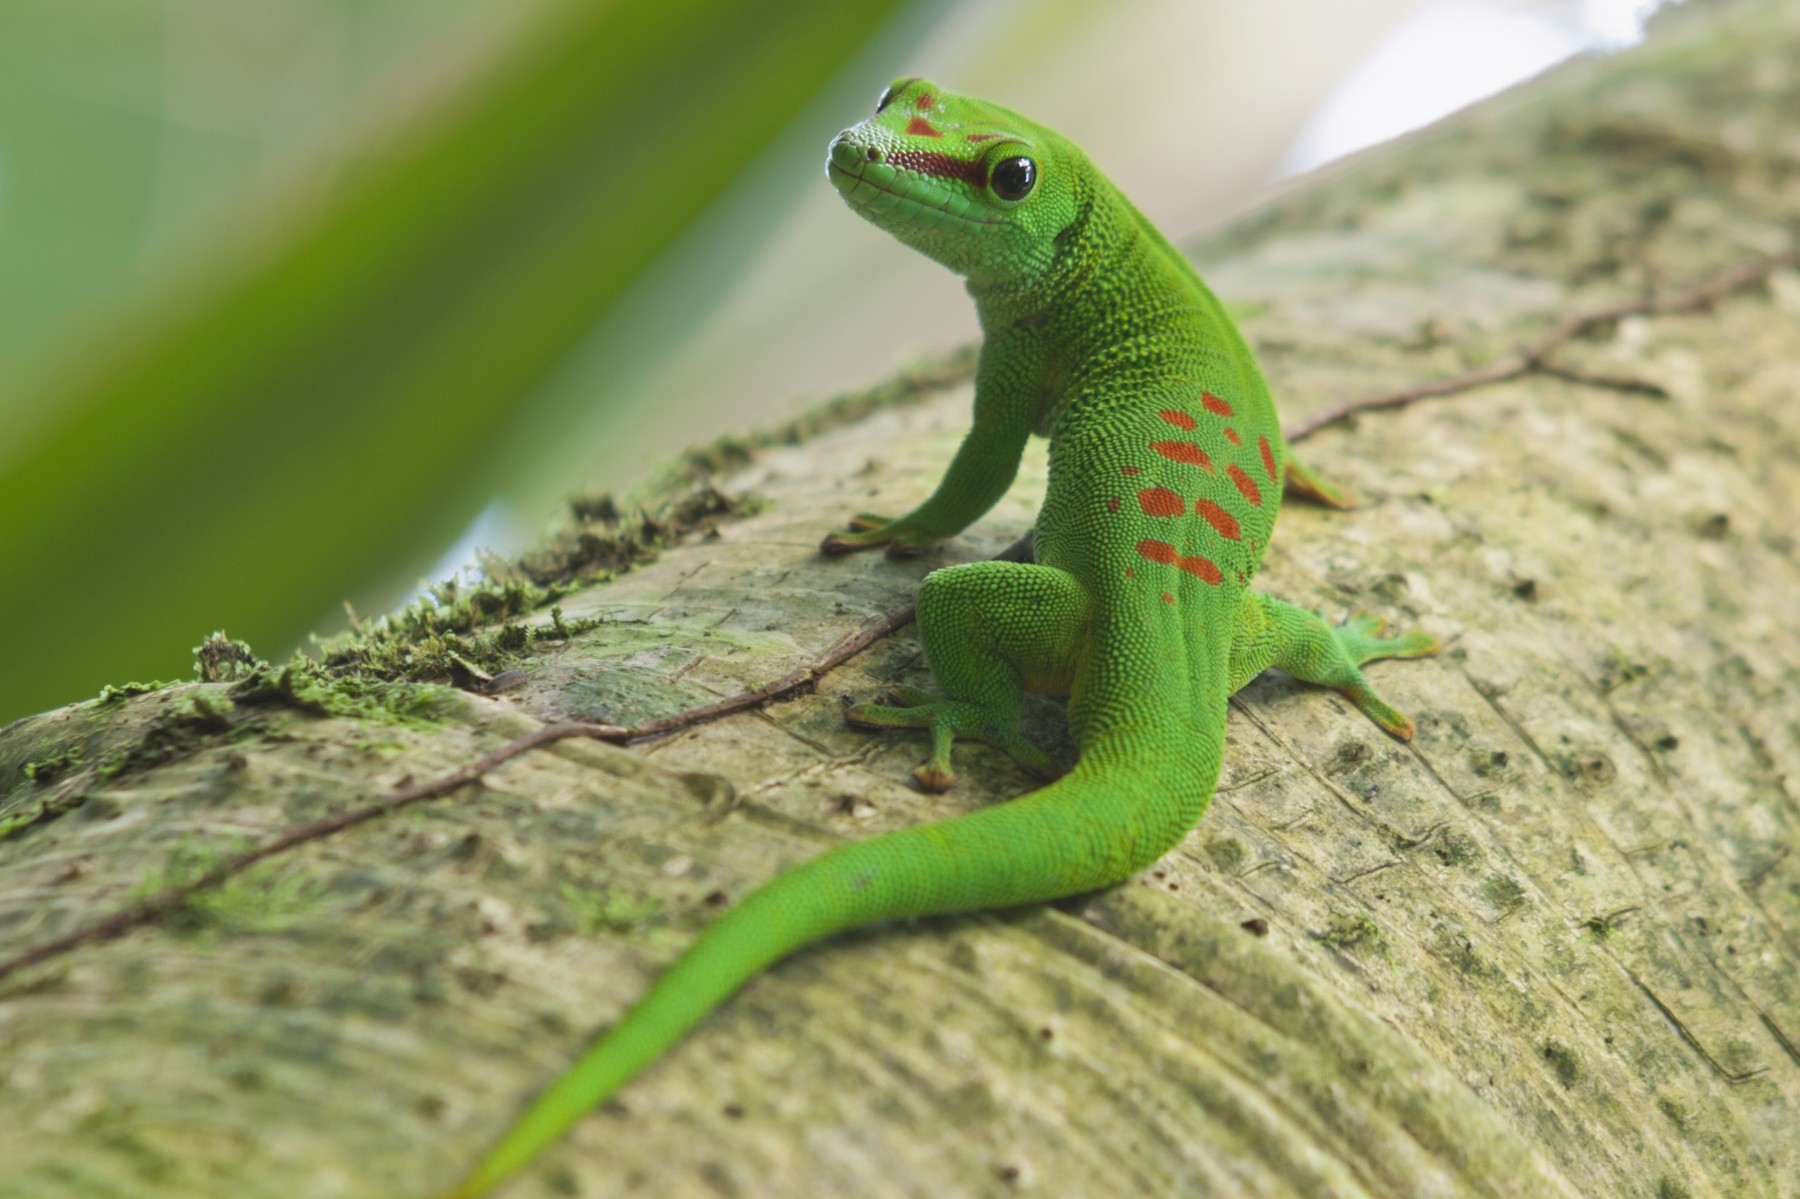

In [43]:
model_builder = keras.applications.EfficientNetV2B0
img_size = (32, 32)
# The local path to our target image
# img_path = keras.utils.get_file(
#     "cow.jpg", "/content/cow.jpg"
# )

display(Image("/content/cow.jpg"))


## The Grad-CAM algorithm

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [30]:
def generate_heatmap_efficientnet_v2(img_array,model , last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Preprocess the input image for EfficientNetV2
    img_array = preprocess_input(img_array)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

## Let's test-drive it

In [50]:
# Prepare image
img_array = preprocess_input(get_img_array("/content/drive/MyDrive/ARC_101_Prompt_Engineering_Intro/beetle.jpg", size=img_size))

In [6]:
model.trainable = False

In [7]:
# Define the last layer for classification
last_layer = model.output
last_layer = GlobalAveragePooling2D()(last_layer)
last_layer = Flatten()(last_layer)
last_layer = Dense(1024, activation='relu')(last_layer)
last_layer = Dense(1024, activation='relu')(last_layer)
last_layer = Dropout(0.5)(last_layer)
last_layer = Dense(1024, activation='relu')(last_layer)
last_layer = Dense(1024, activation='relu')(last_layer)
predictions = Dense(100, activation='softmax')(last_layer)

In [8]:
# Create the modified model
model = Model(inputs=model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 32, 32, 3)            0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 16, 16, 32)           864       ['normalization[0][0]']   

In [35]:
last_conv_layer_name = "block2b_expand_conv"#"block2a_expand_conv"#"top_conv"

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

169001437/169001437 [==============================] - 2s 0us/step


In [12]:
# Preprocess the data
# x_train = keras.applications.vgg16.preprocess_input(x_train)
# x_test = keras.applications.vgg16.preprocess_input(x_test)
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
# Normalize pixel values to be between 0 and 1
# x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1563/1563 [==============================] - 35s 15ms/step - loss: 3.6663 - accuracy: 0.1372 - val_loss: 3.0234 - val_accuracy: 0.2441
Epoch 2/50
1563/1563 [==============================] - 21s 13ms/step - loss: 2.9887 - accuracy: 0.2494 - val_loss: 2.7735 - val_accuracy: 0.2955
Epoch 3/50
1563/1563 [==============================] - 22s 14ms/step - loss: 2.8033 - accuracy: 0.2861 - val_loss: 2.6621 - val_accuracy: 0.3165
Epoch 4/50
1563/1563 [==============================] - 22s 14ms/step - loss: 2.6846 - accuracy: 0.3126 - val_loss: 2.6030 - val_accuracy: 0.3344
Epoch 5/50
1563/1563 [==============================] - 21s 13ms/step - loss: 2.5883 - accuracy: 0.3321 - val_loss: 2.5316 - val_accuracy: 0.3496
Epoch 6/50
1563/1563 [==============================] - 21s 14ms/step - loss: 2.5100 - accuracy: 0.3475 - val_loss: 2.5055 - val_accuracy: 0.3534
Epoch 7/50
1563/1563 [==============================] - 20s 13ms/step - loss: 2.4385 - accuracy: 0.3631 - val_loss: 2.4774 -

KeyboardInterrupt: 

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# model.save('/content/drive/MyDrive/ARC_101_Prompt_Engineering_Intro/Cifar_simple_04.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# Make model
model = model_builder(weights="imagenet",input_shape=(32, 32, 3),include_top=False)

24274472/24274472 [==============================] - 0s 0us/step


In [15]:
# Loads the weights
model.load_weights('/content/drive/MyDrive/ARC_101_Prompt_Engineering_Intro/Cifar_simple_04.h5')

In [16]:
# Evaluate the model on new data
loss, accuracy = model.evaluate(x_test, y_test)

# Print the evaluation results
print('Loss:', loss)
print('Accuracy:', accuracy)

313/313 [==============================] - 24s 65ms/step - loss: 2.6681 - accuracy: 0.4033
Loss: 2.6680850982666016
Accuracy: 0.4032999873161316


In [17]:
# Get the list of classes
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar',
    'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [18]:
# Create a custom decoding function with your custom classes
def custom_decode_predictions(preds, top=5, custom_classes=None):
    if custom_classes is None:
        raise ValueError("Please provide a list of custom classes.")

    # Get the indices of the top predictions
    top_indices = tf.argsort(preds, direction='DESCENDING')[:, :top]

    # Decode the predictions using custom classes
    decoded_predictions = []
    for i in range(top_indices.shape[0]):
        top_classes = [custom_classes[idx] for idx in top_indices[i]]
        decoded_predictions.append(top_classes)

    return decoded_predictions

# Replace YOUR_CUSTOM_CLASSES with your list of 100 class labels
# For example, YOUR_CUSTOM_CLASSES = ['class1', 'class2', ..., 'class100']
# YOUR_CUSTOM_CLASSES = ['class1', 'class2', ..., 'class100']

In [ ]:
# Decode predictions with your custom 100 classes
# custom_decode_predictions = lambda preds: decode_predictions(preds, top=1, custom_classes=cifar100_classes)

In [51]:
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", custom_decode_predictions(preds, top=1, custom_classes=cifar100_classes))

# Generate class activation heatmap
heatmap = generate_heatmap_efficientnet_v2(img_array, model, last_conv_layer_name)

1/1 [==============================] - 0s 38ms/step
Predicted: [['beetle']]


In [52]:
heatmap.shape

(8, 8)

# In the context of class activation maps or gradient-based visualizations, the color intensity in the generated heatmap typically represents the importance or activation level of different regions in the input image. In most visualizations, warmer colors (e.g., red or yellow) indicate higher activations, while cooler colors (e.g., blue) indicate lower activations.

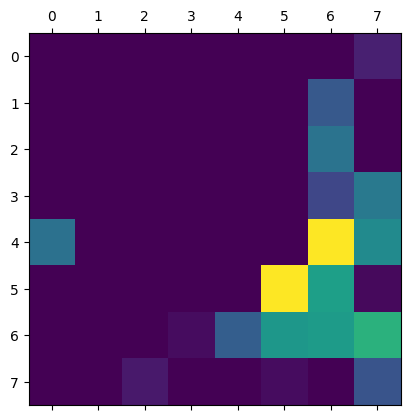

In [53]:
# Remove last layer's softmax
# model.layers[-1].activation = None
# Display heatmap
plt.matshow(heatmap,fignum=None)
plt.show()


## Create a superimposed visualization

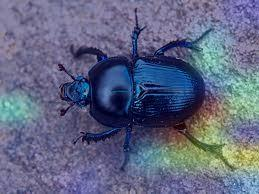

In [54]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam("/content/beetle.jpg", heatmap)